In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

import seaborn as sns
from ast import literal_eval
from pathlib import Path
from itertools import product
import warnings
#import os
#os.chdir("..")
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (12, 3)

In [41]:
dataset_names = {42900: "Breast Cancer Coimbra",
                 41945: "Indian Liver Patients",
                 "thorax": "Coronary Heart Disease",
                 "ACSIncome": "ACSIncome",
                 "cali_housing_binary": "California Housing"}

label_mapping={"lookahead":"Lookahead",
            "method":"Method",
            "score_set": "Score Set",
            "calibration_method": "Calibration",
            "('calibration_method', 'isotonic')":"Isotonic Regression",
            "beta":"Beta Calibration",
            "psl_prebin":"Prebinarization",
            "psl":"In-Search Binarization",
            "psl_logreg": "Stagewise Logistic Regression",
            "stage":"Stage",
            "train_ent":"Expected Entropy",
            "clf_variant": "Variant",
            "bisect":"Bisect",
            "brute":"Bruteforce",
            "test_brier" : "Brier Score",
            "('calibration_method', 'beta')":"Beta Calibration",
            "(('calibration_method', 'beta'), 'psl')":"PSL Beta Calibration (unregularized)", 
            "(('calibration_method', 'beta_reg'), 'psl')":"PSL Beta Calibration", 
            "(('calibration_method', 'isotonic'), 'psl')":"PSL Isotonic Regression",
            "(('calibration_method', 'sigmoid'), 'psl')":"PSL Sigmoid Regression",
            "(('calibration_method', 'isotonic'), 'psl_logreg')": "Stagewise Logistic Regression",
            "(('calibration_method', 'isotonic'), 'psl_logreg_unregularized')": "Stagewise Logistic Regression (unregularized)",
            "(('calibration_method', 'beta'), 'psl_prebin')":"PSL Beta Calibration  (unregularized)", 
            "(('calibration_method', 'beta_reg'), 'psl_prebin')":"PSL Beta Calibration", 
            "(('calibration_method', 'isotonic'), 'psl_prebin')":"PSL Isotonic Regression",
            "(('calibration_method', 'sigmoid'), 'psl_prebin')":"PSL Sigmoid Regression",
            "(('calibration_method', 'isotonic'), 'psl_prebin_logreg')": "Stagewise Logistic Regression",
            "(('calibration_method', 'isotonic'), 'psl_prebin_logreg_unregularized')": "Stagewise Logistic Regression (unregularized)",
            "(('calibration_method', 'isotonic'), 'psl_prebin_xgboost')" : "Stagewise XGBoost",
            "(('calibration_method', 'isotonic'), 'psl_prebin_random_forest')" : "Stagewise Random Forest",
            "(('calibration_method', 'isotonic'), 'psl_xgboost')" : "Stagewise XGBoost",
            "(('calibration_method', 'isotonic'), 'psl_random_forest')" : "Stagewise Random Forest",
            "test_roc" : "ROC AUC",
            "train_roc" : "ROC AUC",
            "soft_ranking_loss": "Soft Rank Loss",
            "expected_entropy":"Expected Entropy",
            "'psl_prebin_logreg'" : "Logistic Regression",
            "('', '')":"",
            "psl_prebin_logreg" : "Logistic Regression"
            }

In [42]:
# load all files
df = pd.concat((pd.read_csv(f) for f in Path("experiments/final/results_rebuttal").glob("*.csv") if f.stat().st_size > 0 ), ignore_index=True)
# remove decision trees
df = df[df.clf != "dt"]
df = df.drop("params",axis=1)
df["test_brier"] = -df["test_brier"]
df["train_brier"] = -df["train_brier"]
# eval columns
struct_cols = ['score_set',"stage_clf_params"]
print(df["score_set"].unique())
print(df["stage_clf_params"].unique())
df[struct_cols] = df[struct_cols].map(literal_eval)

# clean some stuff
df["clf_variant"] = df.clf.str.cat(df.clf_variant, sep="_", na_rep="").str.rstrip("_")
df["stage_loss"] = df["stage_loss"].fillna("expected_entropy")
for ci, sample in product([5, 10, 20, 50, 80, 90, 95, 99], ["train","test"]):
    col = f"{sample}_conservative_wloss{ci}"
    if col in df:
        df[col] = df[col].fillna(df[f'{sample}_wloss'])
display(df)

['(-3, -2, -1, 1, 2, 3)' '(-1, 1)' '(-2, -1, 1, 2)'
 '(-50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50)']
["('calibration_method', 'sigmoid')" "('calibration_method', 'isotonic')"
 "('calibration_method', 'beta')" "('calibration_method', 'beta_reg')"]


,dataset,fold,clf,score_set,lookahead,method,stage_clf_params,fit_time,score_time,test_acc,...,test_conservative_wloss90,train_conservative_wloss95,test_conservative_wloss95,train_conservative_wloss99,test_conservative_wloss99,stage,clf_variant,stage_loss,criterion,max_depth
0,42900,8,psl_prebin,"(-3, -2, -1, 1, 2, 3)",1.0,bisect,"(calibration_method, sigmoid)",1.955959,0.023478,0.666667,...,0.641026,0.324675,0.641026,0.324675,0.641026,NaN,psl_prebin,expected_entropy,NaN,NaN
1,42900,8,psl_prebin,"(-3, -2, -1, 1, 2, 3)",1.0,bisect,"(calibration_method, sigmoid)",NaN,NaN,0.589744,...,0.410256,0.467532,0.410256,0.467532,0.410256,0.0,psl_prebin,expected_entropy,NaN,NaN
2,42900,8,psl_prebin,"(-3, -2, -1, 1, 2, 3)",1.0,bisect,"(calibration_method, sigmoid)",NaN,NaN,0.589744,...,0.410256,0.467532,0.410256,0.467532,0.410256,0.0,psl_prebin_logreg,expected_entropy,NaN,NaN
3,42900,8,psl_prebin,"(-3, -2, -1, 1, 2, 3)",1.0,bisect,"(calibration_method, sigmoid)",NaN,NaN,0.589744,...,0.410256,0.467532,0.410256,0.467532,0.410256,0.0,psl_prebin_logreg_unregularized,expected_entropy,NaN,NaN
4,42900,8,psl_prebin,"(-3, -2, -1, 1, 2, 3)",1.0,bisect,"(calibration_method, sigmoid)",NaN,NaN,0.589744,...,0.410256,0.467532,0.410256,0.467532,0.410256,0.0,psl_prebin_xgboost,expected_entropy,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432195,ACSIncome,92,psl,"(-3, -2, -1, 1, 2, 3)",1.0,bisect,"(calibration_method, isotonic)",NaN,NaN,0.733758,...,0.432848,0.428507,0.432848,0.428507,0.432848,11.0,psl,expected_entropy,NaN,NaN
432196,ACSIncome,92,psl,"(-3, -2, -1, 1, 2, 3)",1.0,bisect,"(calibration_method, isotonic)",NaN,NaN,0.753030,...,0.450000,0.455851,0.450000,0.455851,0.450000,11.0,psl_logreg,expected_entropy,NaN,NaN
432197,ACSIncome,92,psl,"(-3, -2, -1, 1, 2, 3)",1.0,bisect,"(calibration_method, isotonic)",NaN,NaN,0.753212,...,0.450121,0.456030,0.450121,0.456030,0.450121,11.0,psl_logreg_unregularized,expected_entropy,NaN,NaN
432198,ACSIncome,92,psl,"(-3, -2, -1, 1, 2, 3)",1.0,bisect,"(calibration_method, isotonic)",NaN,NaN,0.764848,...,0.406000,0.353104,0.406000,0.353104,0.406000,11.0,psl_xgboost,expected_entropy,NaN,NaN


In [43]:
score_set_strings = [str(s) for s in list(df.score_set.unique())]


fifty = [s for s in score_set_strings if "50" in s]
score_set_strings = [s for s in score_set_strings if "50" not in s]


score_set_latex_labels = [f"$\mathcal{{S}}=\{{{s[1:-1]}\}}$" for s in score_set_strings]
score_set_latex_labels += [f"$\mathcal{{S}}=\{{-50, \\dots, 50\}}$"]

score_set_strings += fifty



# Here I update the label mapping with the score sets in LaTeX notation
label_mapping.update(dict(zip(score_set_strings,score_set_latex_labels)))

In [44]:
df.clf_variant.unique()

array(['psl_prebin', 'psl_prebin_logreg',
       'psl_prebin_logreg_unregularized', 'psl_prebin_xgboost',
       'psl_prebin_random_forest', 'psl', 'psl_logreg',
       'psl_logreg_unregularized', 'psl_xgboost', 'psl_random_forest'],
      dtype=object)

[(('calibration_method', 'beta_reg'), 'psl_prebin')
 (('calibration_method', 'beta_reg'), 'psl_prebin_logreg')
 (('calibration_method', 'isotonic'), 'psl_prebin')
 (('calibration_method', 'isotonic'), 'psl_prebin_logreg')
 (('calibration_method', 'isotonic'), 'psl_prebin_logreg_unregularized')
 (('calibration_method', 'beta'), 'psl_prebin')]
6600


/tmp/ipykernel_251609/283316780.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])], x="stage", y="test_brier", hue=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])][["stage_clf_params", "clf_variant"]].apply(tuple, axis=1) ,palette=["black"], ls=":", errorbar=None, ax=ax, legend="full")
/tmp/ipykernel_251609/283316780.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])], x="stage", y="test_brier", hue=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])][["stage_clf_params", "clf_variant"]].apply(tuple, axis=1) ,palette=["black"], ls=":", errorbar=None, ax=ax, legend="full")
/tmp/ipykernel_251609/283316780.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin"

[(('calibration_method', 'beta'), 'psl_prebin')
 (('calibration_method', 'beta_reg'), 'psl_prebin')
 (('calibration_method', 'beta_reg'), 'psl_prebin_logreg')
 (('calibration_method', 'isotonic'), 'psl_prebin')
 (('calibration_method', 'isotonic'), 'psl_prebin_logreg')
 (('calibration_method', 'isotonic'), 'psl_prebin_logreg_unregularized')]
6000


/tmp/ipykernel_251609/283316780.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])], x="stage", y="test_brier", hue=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])][["stage_clf_params", "clf_variant"]].apply(tuple, axis=1) ,palette=["black"], ls=":", errorbar=None, ax=ax, legend="full")
/tmp/ipykernel_251609/283316780.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])], x="stage", y="test_brier", hue=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])][["stage_clf_params", "clf_variant"]].apply(tuple, axis=1) ,palette=["black"], ls=":", errorbar=None, ax=ax, legend="full")
/tmp/ipykernel_251609/283316780.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin"

[(('calibration_method', 'beta_reg'), 'psl_prebin')
 (('calibration_method', 'beta_reg'), 'psl_prebin_logreg')
 (('calibration_method', 'isotonic'), 'psl_prebin')
 (('calibration_method', 'isotonic'), 'psl_prebin_logreg')
 (('calibration_method', 'isotonic'), 'psl_prebin_logreg_unregularized')
 (('calibration_method', 'beta'), 'psl_prebin')]
6600


/tmp/ipykernel_251609/283316780.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])], x="stage", y="test_brier", hue=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])][["stage_clf_params", "clf_variant"]].apply(tuple, axis=1) ,palette=["black"], ls=":", errorbar=None, ax=ax, legend="full")
/tmp/ipykernel_251609/283316780.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])], x="stage", y="test_brier", hue=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])][["stage_clf_params", "clf_variant"]].apply(tuple, axis=1) ,palette=["black"], ls=":", errorbar=None, ax=ax, legend="full")
/tmp/ipykernel_251609/283316780.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin"

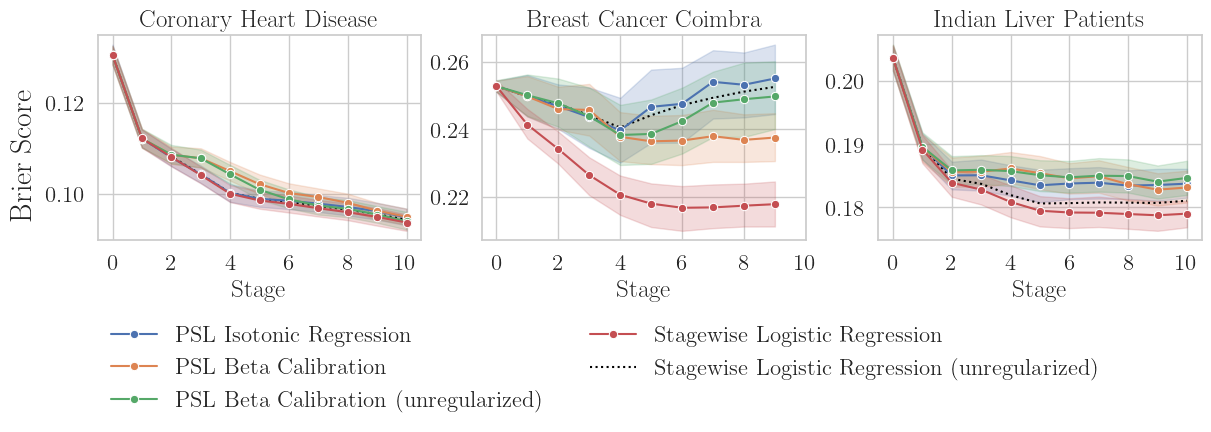

In [45]:
datasets = ["thorax", 42900, 41945]

fig,axes = plt.subplots(1,len(datasets), sharey=False, layout='constrained')
axes = axes.ravel()
hue_order = [(('calibration_method', 'isotonic'), 'psl_prebin'),(('calibration_method', 'beta_reg'), 'psl_prebin'), (('calibration_method', 'beta'), 'psl_prebin'), (('calibration_method', 'isotonic'), 'psl_prebin_logreg')]


for index, dataset in enumerate(datasets):
    ax=axes[index]

    df_ = df[(df.dataset == datasets[index])
    & (df.score_set==(-3, -2, -1, 1, 2, 3))
    & (df.lookahead.isin({None,1}))
    & (df.clf_variant.isin(["psl_prebin", "psl_prebin_logreg", "psl_prebin_logreg_unregularized"]))
    & (df.method.isin(["bisect"]))
    & (~df.stage.isnull())]
    df_ = df_.drop(df_[(df_.clf_variant=="psl_logreg_unregularized") & (df_.stage_clf_params==('calibration_method', 'beta'))].index)
    df_ = df_.drop(df_[(df_.clf_variant=="psl_logreg") & (df_.stage_clf_params==('calibration_method', 'beta'))].index)
    df_ = df_.drop(df_[(df_.clf_variant=="psl_prebin_logreg_unregularized") & (df_.stage_clf_params==('calibration_method', 'beta'))].index)
    df_ = df_.drop(df_[(df_.clf_variant=="psl_prebin_logreg_unregularized") & (df_.stage_clf_params==('calibration_method', 'beta_reg'))].index)
    df_ = df_.drop(df_[(df_.clf_variant=="psl_prebin_logreg") & (df_.stage_clf_params==('calibration_method', 'beta'))].index)
    # df_ = df_.drop(df_[(df_.stage_clf_params==('calibration_method', 'beta_reg'))].index)
    df_ = df_.drop(df_[(df_.stage_clf_params==('calibration_method', 'sigmoid'))].index)
    print(df_[["stage_clf_params", "clf_variant"]].apply(tuple, axis=1).unique())
    if True or dataset==42900:
        sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])], x="stage", y="test_brier", hue=df_[df.clf_variant.isin(["psl_prebin_logreg_unregularized"])][["stage_clf_params", "clf_variant"]].apply(tuple, axis=1) ,palette=["black"], ls=":", errorbar=None, ax=ax, legend="full")
    print(len(df_))
    sns.lineplot(data=df_[df.clf_variant.isin(["psl_prebin", "psl_prebin_logreg"])], x="stage", y="test_brier", hue=df_[["stage_clf_params", "clf_variant"]].apply(tuple, axis=1), hue_order=hue_order, marker="o", ax=ax)
    if index == 1:
        handles, labels = np.array(ax.get_legend_handles_labels())[:,[1,2,3,4,0]]
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

syl = fig.supylabel("Brier Score")
labels = [label_mapping[label] for label in labels]
lgd = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("fig/brier.pdf",bbox_extra_artists=(lgd,syl), bbox_inches='tight')

stage_clf_params                clf_variant             
(calibration_method, isotonic)  psl_prebin                  1100
                                psl_prebin_logreg           1100
                                psl_prebin_random_forest    1100
                                psl_prebin_xgboost          1100
dtype: int64
stage_clf_params                clf_variant             
(calibration_method, isotonic)  psl_prebin                  1200
                                psl_prebin_logreg           1200
                                psl_prebin_random_forest    1200
                                psl_prebin_xgboost          1200
dtype: int64
stage_clf_params                clf_variant             
(calibration_method, isotonic)  psl_prebin                  900
                                psl_prebin_logreg           900
                                psl_prebin_random_forest    900
                                psl_prebin_xgboost          900
dtype: int64


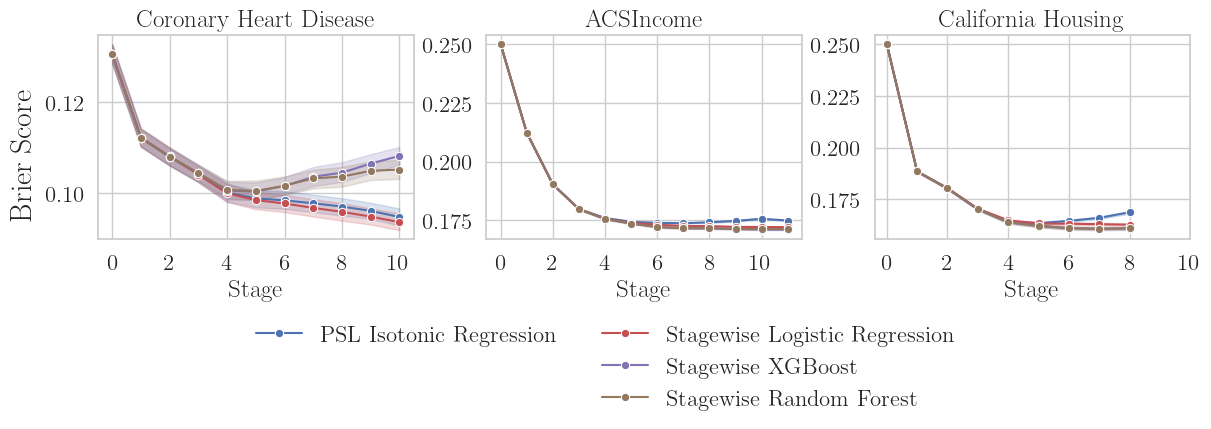

In [46]:
datasets = ["thorax", "ACSIncome", "cali_housing_binary"]

fig,axes = plt.subplots(1,len(datasets), sharey=False, layout='constrained')
axes = axes.ravel()
hue_order = [(('calibration_method', 'isotonic'), 'psl_prebin'), ("",""),("",""), (('calibration_method', 'isotonic'), 'psl_prebin_logreg'),
             (('calibration_method', 'isotonic'), 'psl_prebin_xgboost'),  (('calibration_method', 'isotonic'), 'psl_prebin_random_forest')]


for index, dataset in enumerate(datasets):
    ax=axes[index]

    df_ = df[(df.dataset == datasets[index])
    & (df.score_set==(-3, -2, -1, 1, 2, 3))
    & (df.lookahead.isin({None,1}))
    & (df.clf_variant.isin(["psl_prebin", "psl_prebin_logreg", "psl_prebin_xgboost", "psl_prebin_random_forest"]))
    & (df.method.isin(["bisect"]))
    & (~df.stage.isnull())]
    df_ = df_.drop(df_[(df_.clf_variant=="psl_prebin_logreg") & (df_.stage_clf_params==('calibration_method', 'beta'))].index)
    df_ = df_.drop(df_[(df_.stage_clf_params==('calibration_method', 'beta_reg'))].index)
    df_ = df_.drop(df_[(df_.stage_clf_params==('calibration_method', 'beta'))].index)

    df_ = df_.drop(df_[(df_.stage_clf_params==('calibration_method', 'sigmoid'))].index)
    print(df_.groupby(["stage_clf_params", "clf_variant"]).size())
    # print(df_[["stage_clf_params", "clf_variant"]].apply(tuple, axis=1).unique())
    sns.lineplot(data=df_,
                 x="stage", y="test_brier", hue=df_[["stage_clf_params", "clf_variant"]].apply(tuple, axis=1), hue_order=hue_order, marker="o", ax=ax)
    if index == 1:
        handles, labels = np.array(ax.get_legend_handles_labels())[:,[0,2,3,4]]
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

syl = fig.supylabel("Brier Score")
labels = [label_mapping[label] for label in labels]
handles = list(handles)

proxy = Line2D([], [], linestyle='-', linewidth=0, color='white')
handles.insert(1,proxy)
labels.insert(1," ")
handles.insert(1,proxy)
labels.insert(1," ")
lgd = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("fig/brier_2.pdf",bbox_extra_artists=(lgd,syl), bbox_inches='tight')

stage_clf_params                clf_variant             
(calibration_method, isotonic)  psl_prebin                  1000
                                psl_prebin_logreg           1000
                                psl_prebin_random_forest    1000
                                psl_prebin_xgboost          1000
dtype: int64
stage_clf_params                clf_variant             
(calibration_method, isotonic)  psl_prebin                  1200
                                psl_prebin_logreg           1200
                                psl_prebin_random_forest    1200
                                psl_prebin_xgboost          1200
dtype: int64
stage_clf_params                clf_variant             
(calibration_method, isotonic)  psl_prebin                  900
                                psl_prebin_logreg           900
                                psl_prebin_random_forest    900
                                psl_prebin_xgboost          900
dtype: int64
stage_clf_para

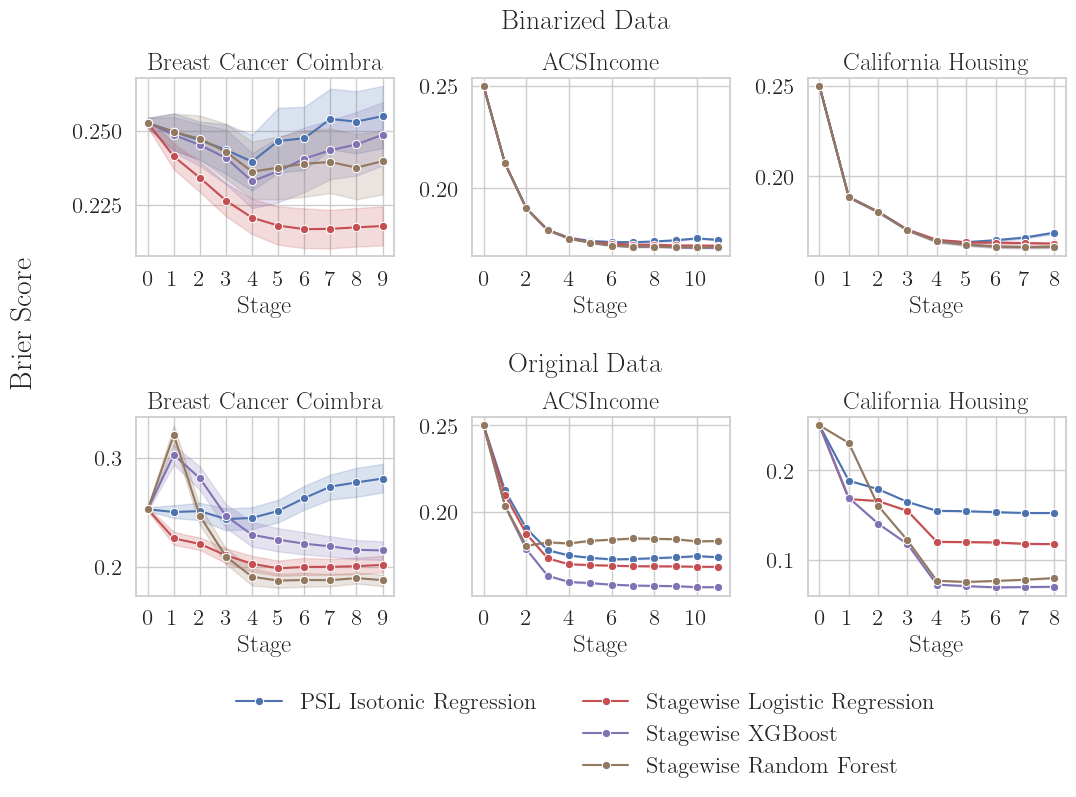

In [74]:


datasets = [42900, "ACSIncome", "cali_housing_binary"]

fig,axes = plt.subplots(2,len(datasets), sharey=False)
# plt.subplots_adjust(hspace=200.0)
fig.set_size_inches(12, 7)

# axes = axes.ravel()
hue_order = [(('calibration_method', 'isotonic'), 'psl_prebin'), ("",""),("",""), (('calibration_method', 'isotonic'), 'psl_prebin_logreg'),
             (('calibration_method', 'isotonic'), 'psl_prebin_xgboost'),  (('calibration_method', 'isotonic'), 'psl_prebin_random_forest')]

txt1 = fig.text(0.5, 0.92, 'Binarized Data', ha='center', fontsize=20, fontweight='bold')

for index, dataset in enumerate(datasets):
    ax=axes[0,index]

    df_bin = df[(df.dataset == datasets[index])
    & (df.score_set==(-3, -2, -1, 1, 2, 3))
    & (df.lookahead.isin({None,1}))
    & (df.clf_variant.isin(["psl_prebin", "psl_prebin_logreg", "psl_prebin_xgboost", "psl_prebin_random_forest"]))
    & (df.method.isin(["bisect"]))
    & (~df.stage.isnull())]
    df_bin = df_bin.drop(df_bin[(df_bin.clf_variant=="psl_prebin_logreg") & (df_bin.stage_clf_params==('calibration_method', 'beta'))].index)
    df_bin = df_bin.drop(df_bin[(df_bin.stage_clf_params==('calibration_method', 'beta_reg'))].index)
    df_bin = df_bin.drop(df_bin[(df_bin.stage_clf_params==('calibration_method', 'beta'))].index)

    df_bin = df_bin.drop(df_bin[(df_bin.stage_clf_params==('calibration_method', 'sigmoid'))].index)
    print(df_bin.groupby(["stage_clf_params", "clf_variant"]).size())
    # print(df_bin[["stage_clf_params", "clf_variant"]].apply(tuple, axis=1).unique())
    sns.lineplot(data=df_bin,
                 x="stage", y="test_brier", hue=df_bin[["stage_clf_params", "clf_variant"]].apply(tuple, axis=1), hue_order=hue_order, marker="o", ax=ax)
    if index == 1:
        handles, labels = np.array(ax.get_legend_handles_labels())[:,[0,2,3,4]]
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    # ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

hue_order = [(('calibration_method', 'isotonic'), 'psl'), ("",""),("",""), (('calibration_method', 'isotonic'), 'psl_logreg'),
             (('calibration_method', 'isotonic'), 'psl_xgboost'),  (('calibration_method', 'isotonic'), 'psl_random_forest')]

txt2 = fig.text(0.5, 0.43, 'Original Data', ha='center', fontsize=20, fontweight='bold')

for index, dataset in enumerate(datasets):
    ax=axes[1,index]

    df_num = df[(df.dataset == datasets[index])
    & (df.score_set==(-3, -2, -1, 1, 2, 3))
    & (df.lookahead.isin({None,1}))
    & (df.clf_variant.isin(["psl", "psl_logreg", "psl_xgboost", "psl_random_forest"]))
    & (df.method.isin(["bisect"]))
    & (df.stage_loss.isin(["expected_entropy"]))
    & (~df.stage.isnull())]
    df_num = df_num.drop(df_num[(df_num.clf_variant=="psl_prebin_logreg")].index)
    df_num = df_num.drop(df_num[(df_num.stage_clf_params==('calibration_method', 'beta_reg'))].index)
    df_num = df_num.drop(df_num[(df_num.stage_clf_params==('calibration_method', 'beta'))].index)

    df_num = df_num.drop(df_num[(df_num.stage_clf_params==('calibration_method', 'sigmoid'))].index)
    print(df_num.groupby(["stage_clf_params", "clf_variant"]).size())
    # print(df_num[["stage_clf_params", "clf_variant"]].apply(tuple, axis=1).unique())
    sns.lineplot(data=df_num,
                 x="stage", y="test_brier", hue=df_num[["stage_clf_params", "clf_variant"]].apply(tuple, axis=1), hue_order=hue_order, marker="o", ax=ax)
    if index == 1:
        handles, labels = np.array(ax.get_legend_handles_labels())[:,[0,2,3,4]]
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    # ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

syl = fig.supylabel("Brier Score")
labels = [label_mapping[label] for label in labels]
handles = list(handles)

proxy = Line2D([], [], linestyle='-', linewidth=0, color='white')
handles.insert(1,proxy)
labels.insert(1," ")
handles.insert(1,proxy)
# fig.tight_layout(rect=(0, 0, 1, 0.9))
plt.subplots_adjust(top=0.85, wspace=0.3, hspace=0.9)

labels.insert(1," ")

lgd = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("fig/brier_binary_vs_numerical.pdf",bbox_extra_artists=(lgd,syl,txt1,txt2), bbox_inches='tight')

stage_loss
expected_entropy    4000
Name: count, dtype: int64
stage_loss
expected_entropy    4400
Name: count, dtype: int64


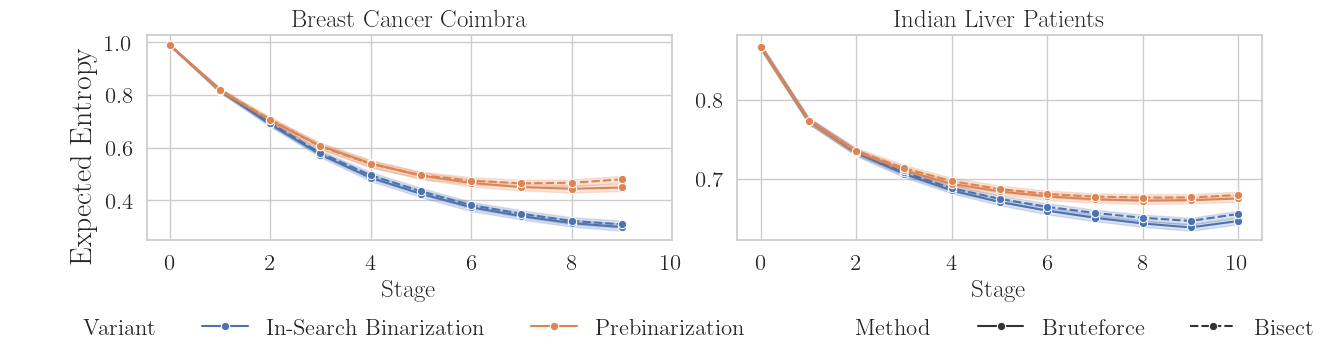

In [48]:

datasets = [42900, 41945]

fig,axes = plt.subplots(1,len(datasets), layout="constrained")
axes = axes.ravel()

hue_order = ["psl", "psl_prebin"]
style_order = ["brute", "bisect"]

for index, dataset in enumerate(datasets):
    ax=axes[index]
    df_ = df[
    (df.dataset == datasets[index])
    & (df.score_set==(-3, -2, -1, 1, 2, 3)) 
    & (df.lookahead.isin({None,1})) 
    & (df.clf_variant.isin(["psl","psl_prebin"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())
    & (df.stage_loss=="expected_entropy")]    
    print(df_["stage_loss"].value_counts())
    sns.lineplot(data=df_, x="stage", y="train_ent", hue="clf_variant", style="method", hue_order=hue_order, style_order=style_order, marker="o", ax=ax)
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
syl = fig.supylabel("Expected Entropy")
handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
lgd = fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.18), frameon=False)
plt.savefig("fig/binarization.pdf", bbox_extra_artists=(lgd,syl), bbox_inches="tight")

stage_clf_params                clf_variant      
(calibration_method, isotonic)  psl                  3000
                                psl_logreg           1000
                                psl_random_forest    1000
                                psl_xgboost          1000
dtype: int64
stage_clf_params                clf_variant      
(calibration_method, isotonic)  psl                  3300
                                psl_logreg           1100
                                psl_random_forest    1100
                                psl_xgboost          1100
dtype: int64
stage_clf_params                clf_variant      
(calibration_method, isotonic)  psl                  3600
                                psl_logreg           1200
                                psl_random_forest    1200
                                psl_xgboost          1200
dtype: int64
stage_clf_params                clf_variant      
(calibration_method, isotonic)  psl                  2700
       

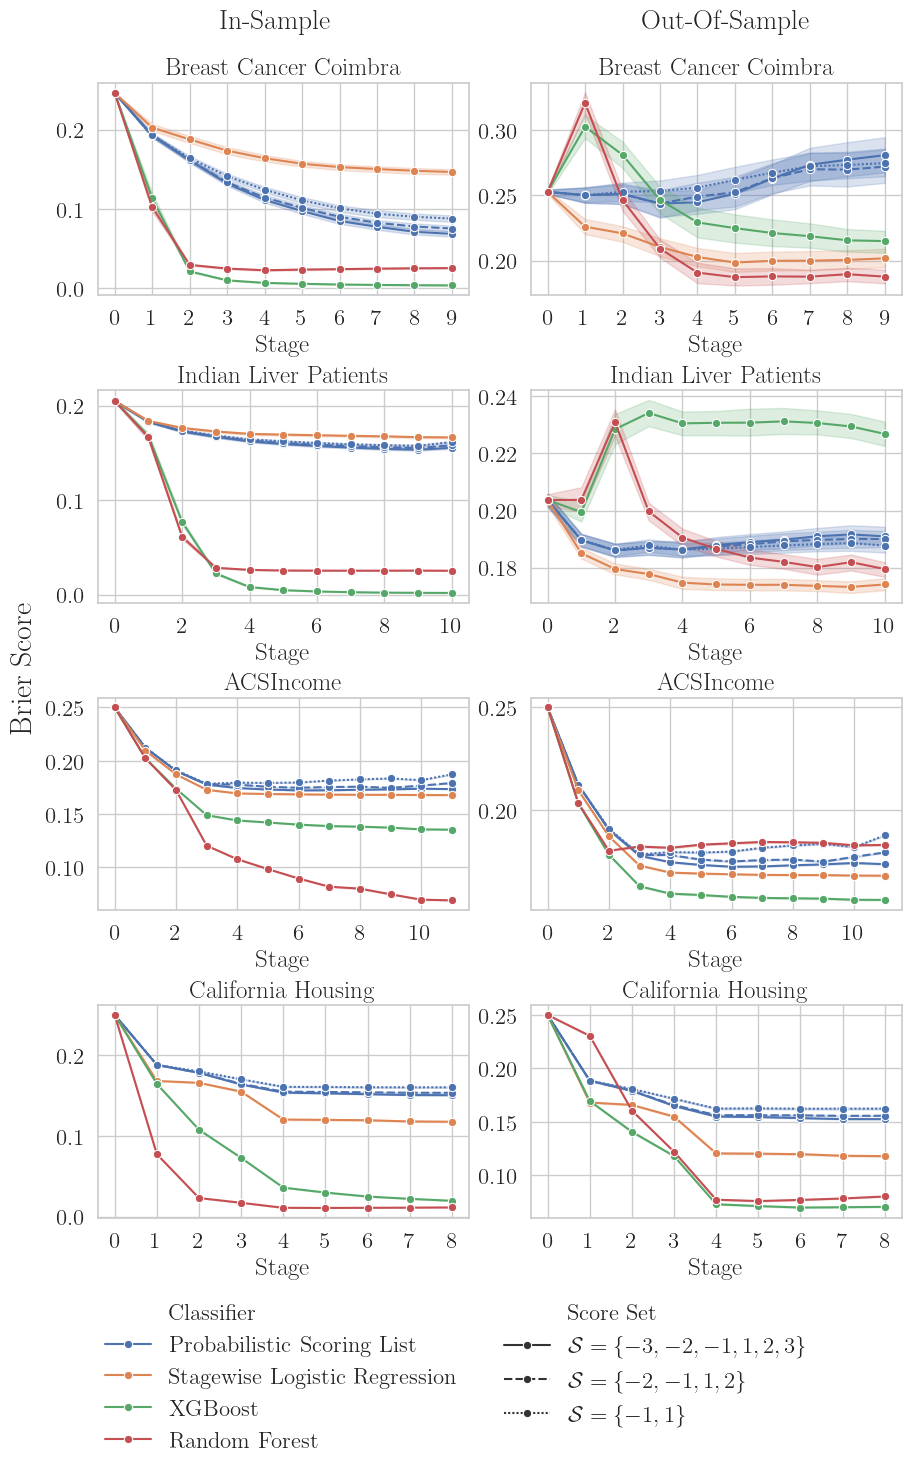

In [85]:
import math
import matplotlib.gridspec as gridspec

datasets = [42900, 41945, "ACSIncome", "cali_housing_binary"]

fig,axes = plt.subplots(len(datasets),2, sharey=False, layout='constrained')
fig.set_size_inches(9.0, 0.82 * 15)

hue_order = ["psl", "psl_logreg", "psl_xgboost", "psl_random_forest"]
# style_order = [tuple(list(range(-50, 0)) + list(range(1, 51))), (-3, -2, -1, 1, 2, 3), (-2, -1, 1, 2), (-1, 1)]
style_order = [(-3, -2, -1, 1, 2, 3), (-2, -1, 1, 2), (-1, 1)]


for index, dataset in enumerate(datasets):
    ax_train=axes[index,0]
    ax_test=axes[index,1]
    
    df_ = df[(df.dataset == datasets[index])
    & (df.lookahead.isin({None,1}))
    & (df.clf_variant.isin(["psl", "psl_logreg", "psl_xgboost", "psl_random_forest"]))
    # & (df.clf_variant.isin(["psl", "psl_logreg"]))
    & (df.method.isin(["bisect"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())
    & (df.stage_loss=="expected_entropy")]
    
    # Use scoreset -3 till 3 for stagewise baselines
    df_ = df_.drop(df_[(df_.clf_variant=="psl_logreg") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
    df_ = df_.drop(df_[(df_.clf_variant=="psl_xgboost") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
    df_ = df_.drop(df_[(df_.clf_variant=="psl_random_forest") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
    df_ = df_.drop(df_[(df_.clf_variant=="psl") & (df_.score_set==tuple(list(range(-50, 0)) + list(range(1, 51))))].index)

    sns.lineplot(data=df_, x="stage", y="train_brier", hue="clf_variant", style="score_set", hue_order=hue_order, style_order=style_order, marker="o", ax=ax_train)
    sns.lineplot(data=df_, x="stage", y="test_brier", hue="clf_variant", style="score_set", hue_order=hue_order, style_order=style_order, marker="o", ax=ax_test)
    print(df_.groupby(["stage_clf_params", "clf_variant"]).size())

    #print(len(df_))
    #print(df_.score_set.value_counts())
    for ax in [ax_train, ax_test]:
        ax.get_legend().remove()
        ax.set_title(dataset_names[dataset])
        ax.set_ylabel(None)
        ax.set_xlabel("Stage")
        # ax.set_xticks(list(range(0,11)))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
syl = fig.supylabel("Brier Score")
label_mapping["psl"] = "Probabilistic Scoring List"
label_mapping["clf_variant"] = "Classifier"
label_mapping["psl_xgboost"] = "XGBoost"
label_mapping["psl_random_forest"] = "Random Forest"

handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
proxy = Line2D([], [], linestyle='-', linewidth=0, color='white')
# handles.insert(3,proxy)
# labels.insert(3," ")
lgd = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
fig.text(0.3, 1.02, "In-Sample", ha='center', fontsize=20)
fig.text(0.8, 1.02, 'Out-Of-Sample', ha='center', fontsize=20)
plt.savefig("fig/brier_appendix_continuous.pdf", bbox_inches='tight')

stage_clf_params                clf_variant             
(calibration_method, isotonic)  psl_prebin                  3300
                                psl_prebin_logreg           1100
                                psl_prebin_random_forest    1100
                                psl_prebin_xgboost          1100
dtype: int64
stage_clf_params                clf_variant             
(calibration_method, isotonic)  psl_prebin                  3000
                                psl_prebin_logreg           1000
                                psl_prebin_random_forest    1000
                                psl_prebin_xgboost          1000
dtype: int64
stage_clf_params                clf_variant             
(calibration_method, isotonic)  psl_prebin                  3300
                                psl_prebin_logreg           1100
                                psl_prebin_random_forest    1100
                                psl_prebin_xgboost          1100
dtype: int64
stage_clf_

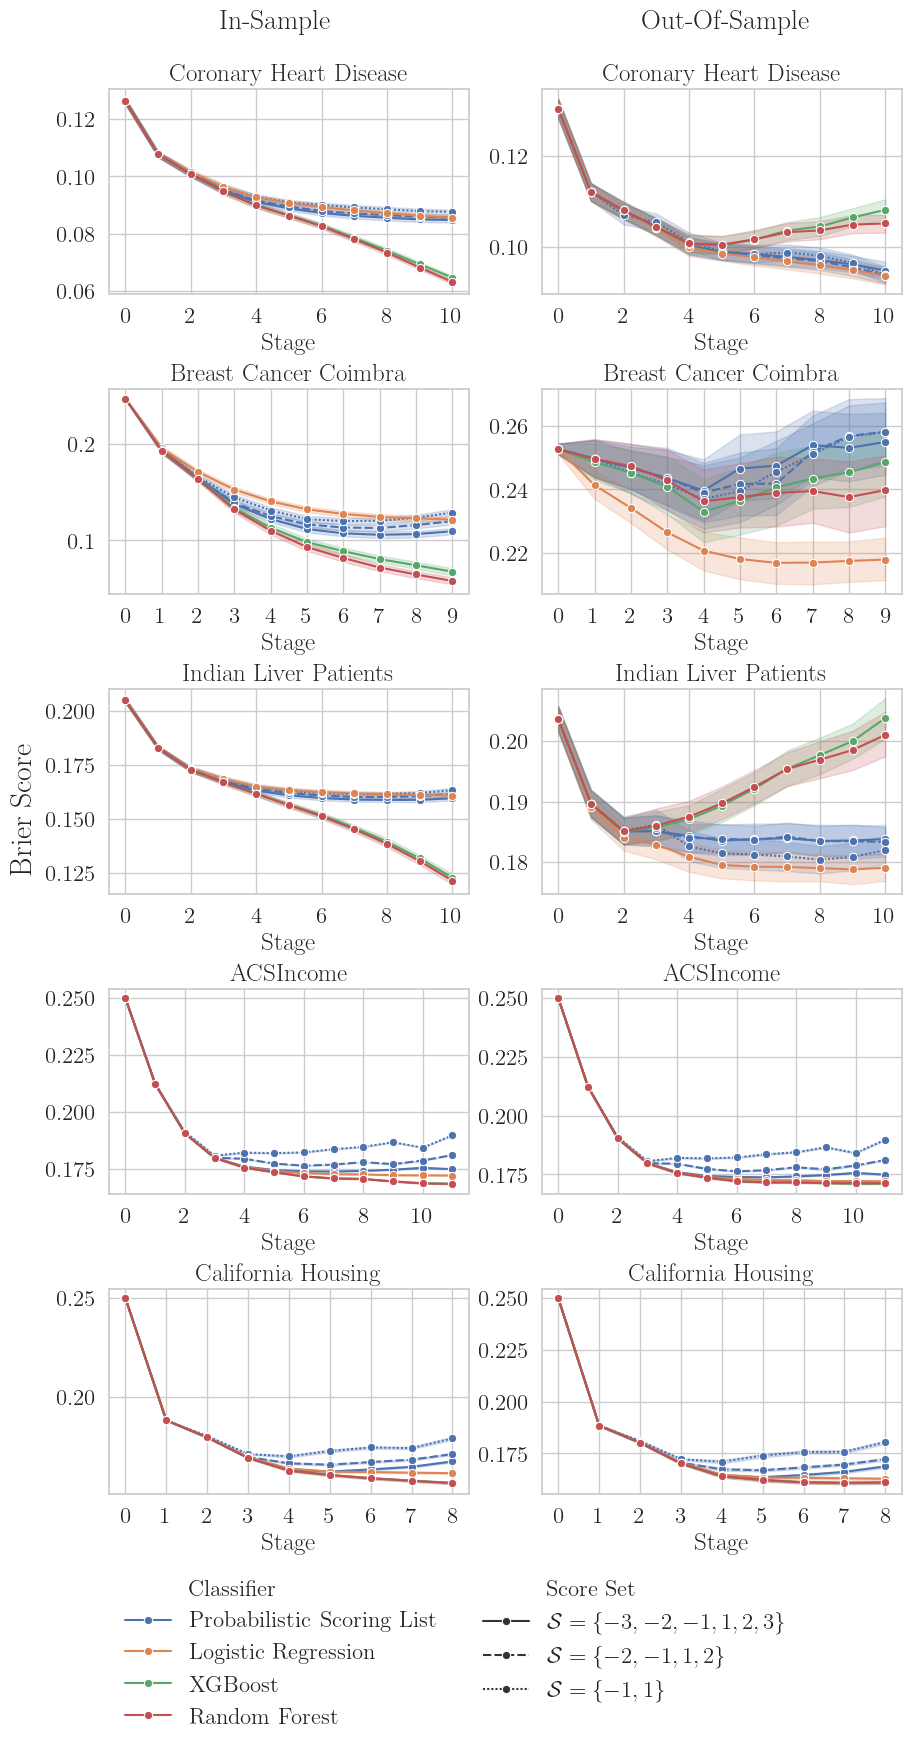

In [83]:
import math
import matplotlib.gridspec as gridspec

datasets = ["thorax", 42900, 41945, "ACSIncome", "cali_housing_binary"]

fig,axes = plt.subplots(len(datasets),2, sharey=False, layout='constrained')
fig.set_size_inches(9.0, 15)

hue_order = ["psl_prebin", "psl_prebin_logreg", "psl_prebin_xgboost", "psl_prebin_random_forest"]
style_order = [tuple(list(range(-50, 0)) + list(range(1, 51))), (-3, -2, -1, 1, 2, 3), (-2, -1, 1, 2), (-1, 1)]
style_order = [(-3, -2, -1, 1, 2, 3), (-2, -1, 1, 2), (-1, 1)]


for index, dataset in enumerate(datasets):
    ax_train=axes[index,0]
    ax_test=axes[index,1]
    
    df_ = df[(df.dataset == datasets[index])
    & (df.lookahead.isin({None,1}))
    & (df.clf_variant.isin(["psl_prebin", "psl_prebin_logreg", "psl_prebin_xgboost", "psl_prebin_random_forest"]))
    # & (df.clf_variant.isin(["psl_prebin", "psl_prebin_logreg"]))
    & (df.method.isin(["bisect"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())
    & (df.stage_loss=="expected_entropy")]
    
    # Use scoreset -3 till 3 for stagewise baselines
    df_ = df_.drop(df_[(df_.clf_variant=="psl_prebin_logreg") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
    df_ = df_.drop(df_[(df_.clf_variant=="psl_prebin_xgboost") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
    df_ = df_.drop(df_[(df_.clf_variant=="psl_prebin_random_forest") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
    df_ = df_.drop(df_[(df_.clf_variant=="psl_prebin") & (df_.score_set==tuple(list(range(-50, 0)) + list(range(1, 51))))].index)

    print(df_.groupby(["stage_clf_params", "clf_variant"]).size())

    sns.lineplot(data=df_, x="stage", y="train_brier", hue="clf_variant", style="score_set", hue_order=hue_order, style_order=style_order, marker="o", ax=ax_train)
    sns.lineplot(data=df_, x="stage", y="test_brier", hue="clf_variant", style="score_set", hue_order=hue_order, style_order=style_order, marker="o", ax=ax_test)
    #print(len(df_))
    #print(df_.score_set.value_counts())
    for ax in [ax_train, ax_test]:
        ax.get_legend().remove()
        ax.set_title(dataset_names[dataset])
        ax.set_ylabel(None)
        ax.set_xlabel("Stage")
        # ax.set_xticks(list(range(0,11)))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
syl = fig.supylabel("Brier Score")
label_mapping["psl_prebin"] = "Probabilistic Scoring List"
label_mapping["clf_variant"] = "Classifier"
label_mapping["psl_prebin_xgboost"] = "XGBoost"
label_mapping["psl_prebin_random_forest"] = "Random Forest"

handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
proxy = Line2D([], [], linestyle='-', linewidth=0, color='white')
# handles.insert(3,proxy)
# labels.insert(3," ")
lgd = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
fig.text(0.3, 1.02, "In-Sample", ha='center', fontsize=20)
fig.text(0.8, 1.02, 'Out-Of-Sample', ha='center', fontsize=20)
plt.savefig("fig/brier_appendix_binary.pdf", bbox_inches='tight')

clf_variant        score_set            
psl_prebin         (-3, -2, -1, 1, 2, 3)    1100
                   (-2, -1, 1, 2)           1100
                   (-1, 1)                  1100
psl_prebin_logreg  (-3, -2, -1, 1, 2, 3)    1100
dtype: int64
clf_variant        score_set            
psl_prebin         (-3, -2, -1, 1, 2, 3)    1000
                   (-2, -1, 1, 2)           1000
                   (-1, 1)                  1000
psl_prebin_logreg  (-3, -2, -1, 1, 2, 3)    1000
dtype: int64
clf_variant        score_set            
psl_prebin         (-3, -2, -1, 1, 2, 3)    1100
                   (-2, -1, 1, 2)           1100
                   (-1, 1)                  1100
psl_prebin_logreg  (-3, -2, -1, 1, 2, 3)    1100
dtype: int64
clf_variant        score_set            
psl_prebin         (-3, -2, -1, 1, 2, 3)    1100
                   (-2, -1, 1, 2)           1100
                   (-1, 1)                  1100
psl_prebin_logreg  (-3, -2, -1, 1, 2, 3)    1100
dtype: int64


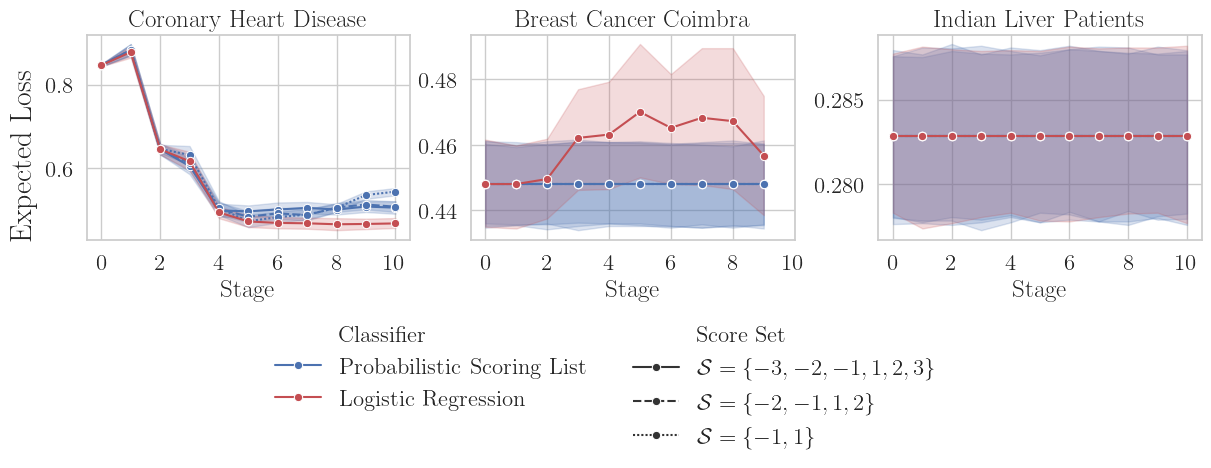

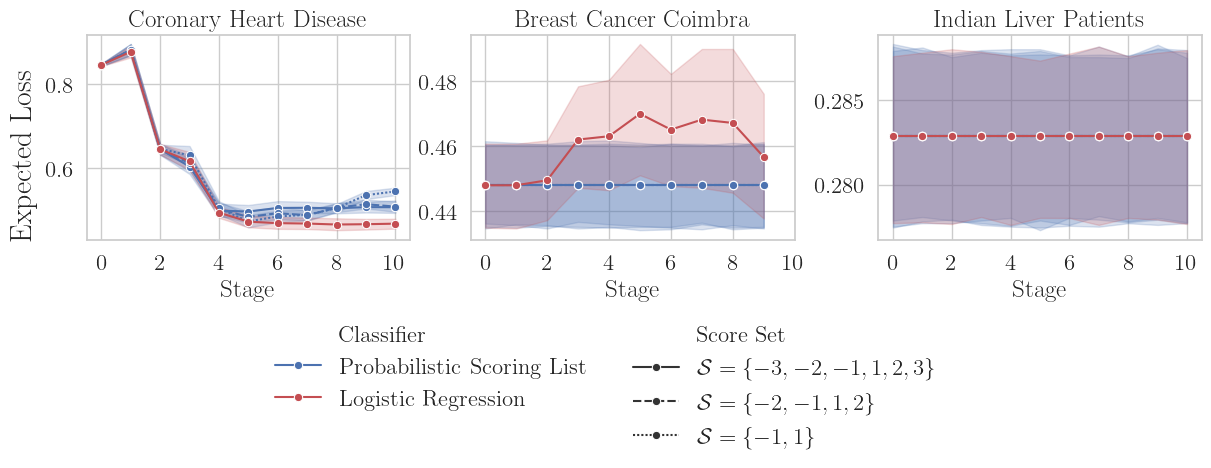

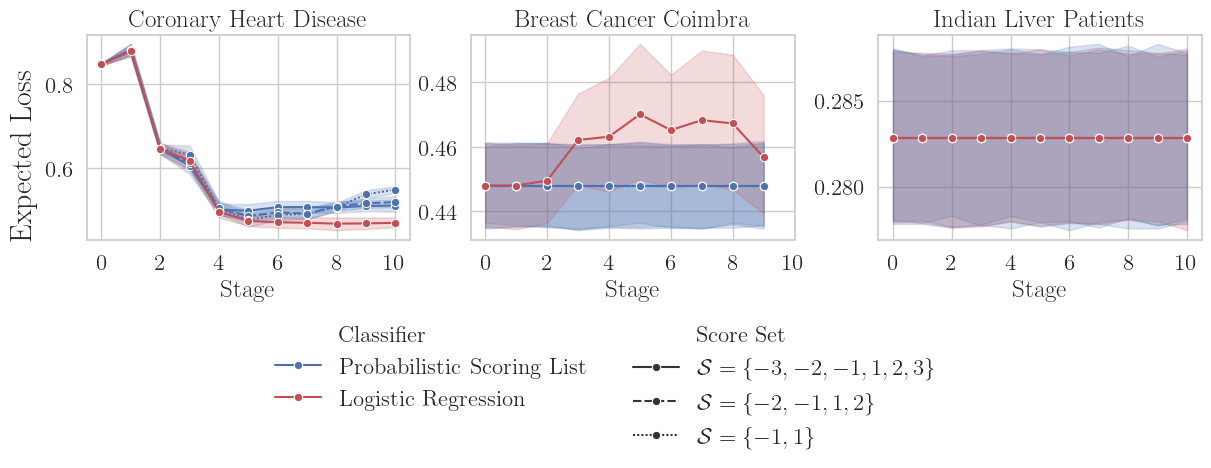

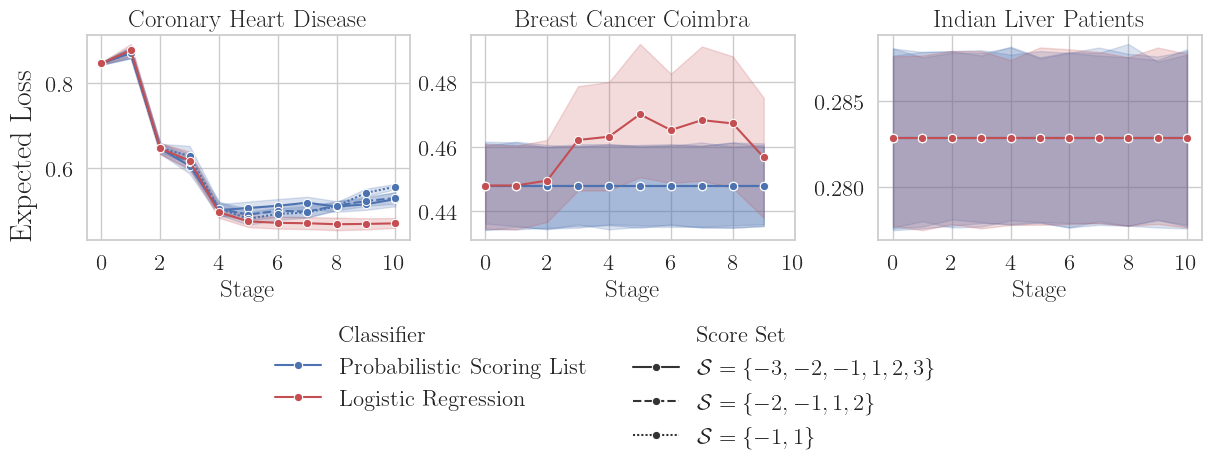

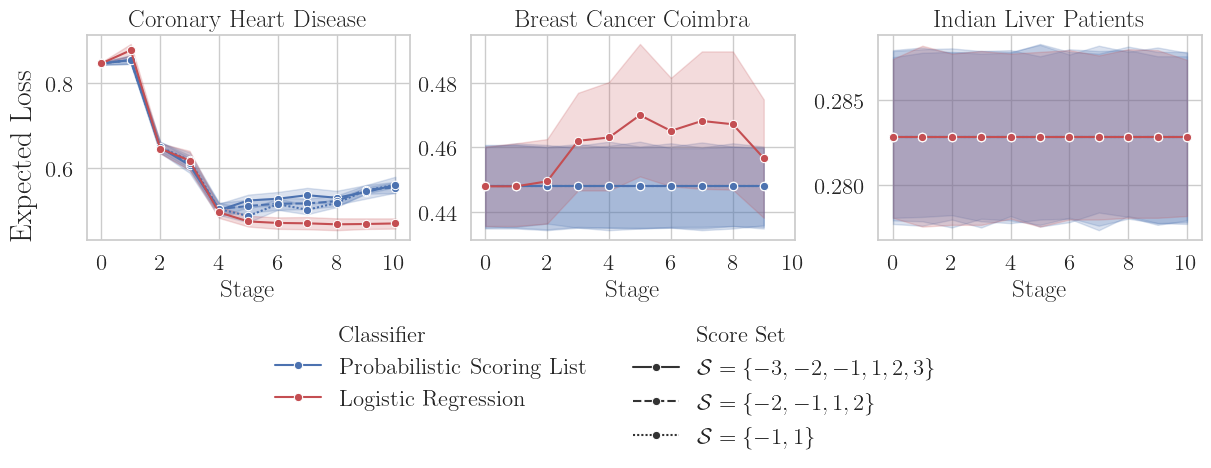

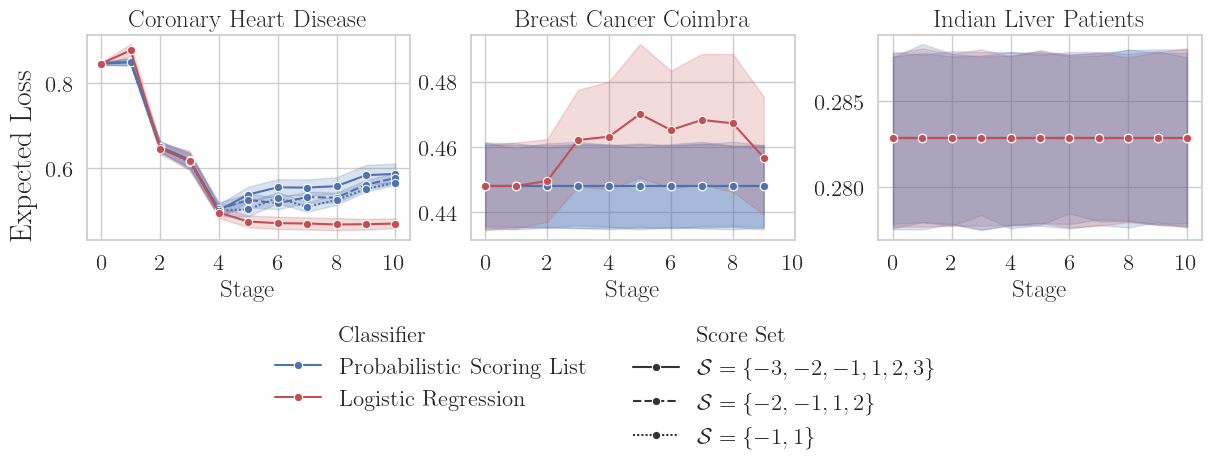

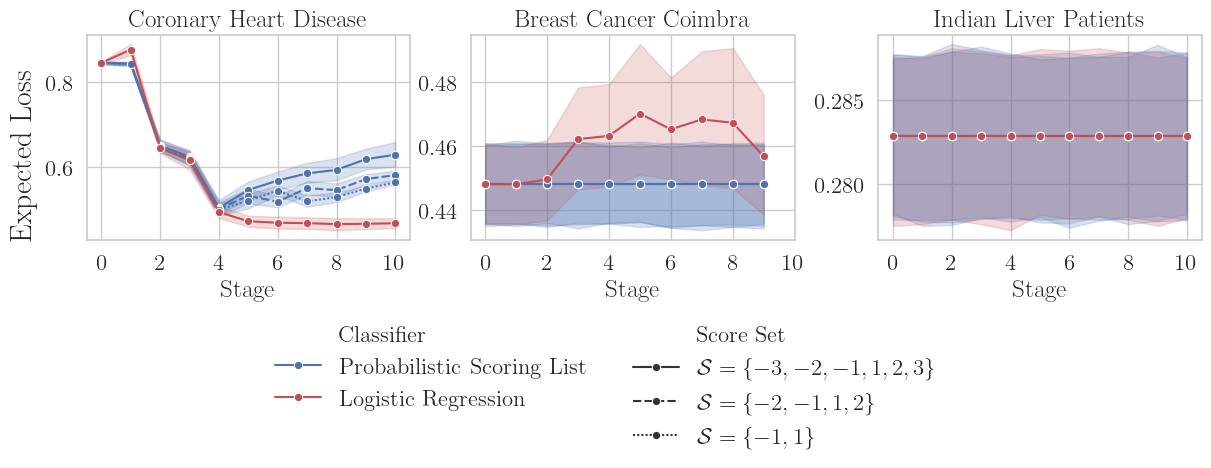

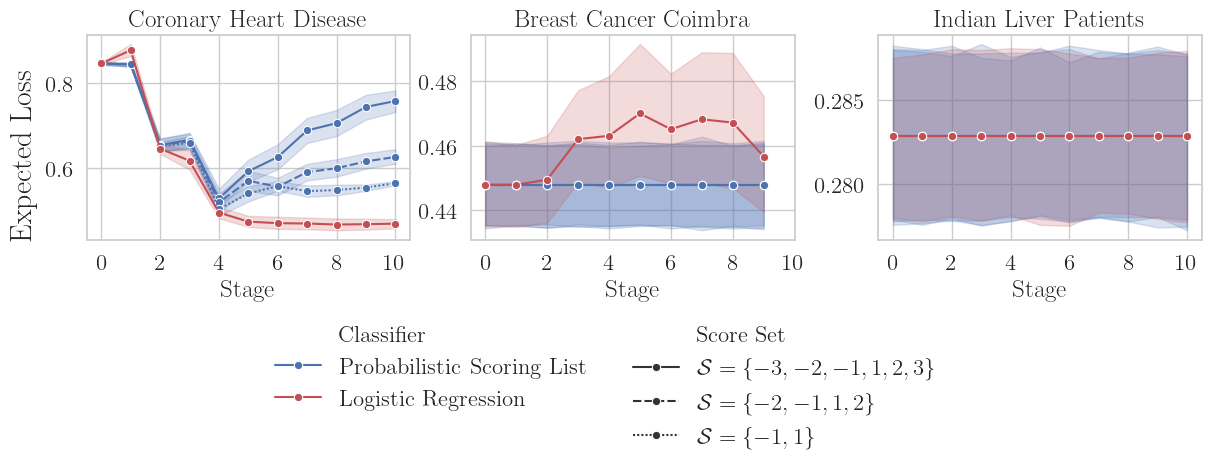

In [51]:
datasets = ["thorax", 42900, 41945]


for ci in [5, 10, 20, 50, 80, 90, 95, 99]:

    fig,axes = plt.subplots(1,len(datasets), sharey=False, layout='constrained')
    axes = axes.ravel()

    hue_order = ["psl_prebin", "","", "psl_prebin_logreg"]
    style_order = [(-3, -2, -1, 1, 2, 3), (-2, -1, 1, 2), (-1, 1)]


    for index, dataset in enumerate(datasets):
        ax=axes[index]

        df_ = df[(df.dataset == datasets[index])
        & (df.lookahead.isin({None,1}))
        & (df.clf_variant.isin(["psl_prebin", "psl_prebin_logreg"]))
        & (df.method.isin(["bisect"]))
        & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
        & (~df.stage.isnull())
        & (df.stage_loss=="expected_entropy")]
        

        df_ = df_.drop(df_[(df_.clf_variant=="psl_prebin_logreg") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
        df_ = df_.drop(df_[(df_.clf_variant=="psl_xgboost") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
        df_ = df_.drop(df_[(df_.clf_variant=="psl_random_forest") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
        df_ = df_.drop(df_[(df_.score_set == tuple(list(range(-50, 0)) + list(range(1, 51))))].index)
        sns.lineplot(data=df_, x="stage", y=f"test_conservative_wloss{ci}", hue="clf_variant", style="score_set", hue_order=hue_order, style_order=style_order, marker="o", ax=ax)
        #print(len(df_))
        #print(df_.score_set.value_counts())
        ax.get_legend().remove()
        ax.set_title(dataset_names[dataset])
        ax.set_ylabel(None)
        ax.set_xlabel("Stage")
        ax.set_xticks(list(range(0,11)))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        print(df_.groupby(["clf_variant", "score_set"]).size())
    syl = fig.supylabel(f"Expected Loss")
    label_mapping["psl"] = "Probabilistic Scoring List"
    label_mapping["clf_variant"] = "Classifier"

    handles, labels = ax.get_legend_handles_labels()
    labels = [label_mapping[label] for label in labels]
    proxy = Line2D([], [], linestyle='-', linewidth=0, color='white')
    handles.insert(3,proxy)
    labels.insert(3," ")
    lgd = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
    plt.savefig(f"fig/expected_loss_{ci}ci.pdf", bbox_inches='tight')

clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1000
             (-2, -1, 1, 2)           1000
             (-1, 1)                  1000
psl_logreg   (-3, -2, -1, 1, 2, 3)    1000
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64


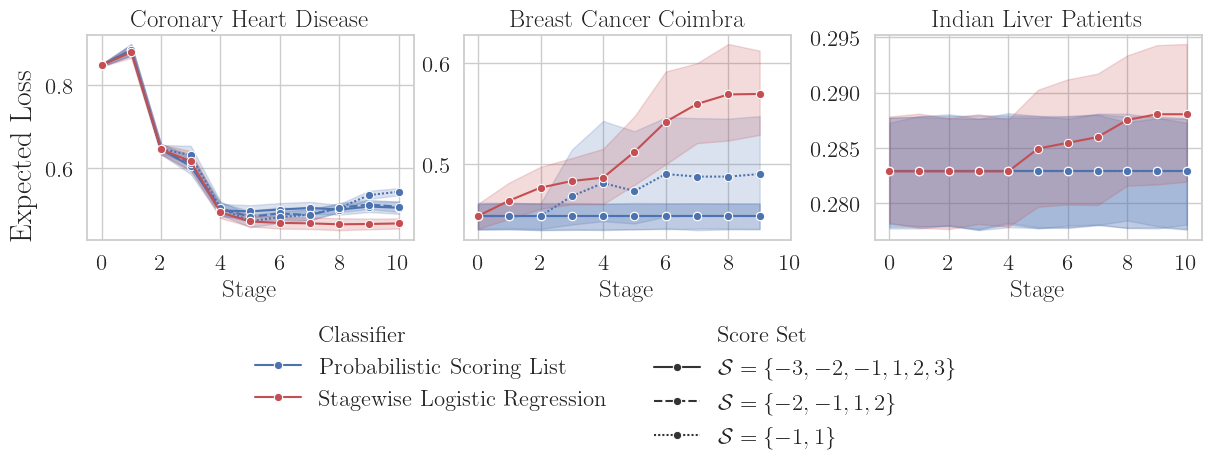

clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1000
             (-2, -1, 1, 2)           1000
             (-1, 1)                  1000
psl_logreg   (-3, -2, -1, 1, 2, 3)    1000
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64


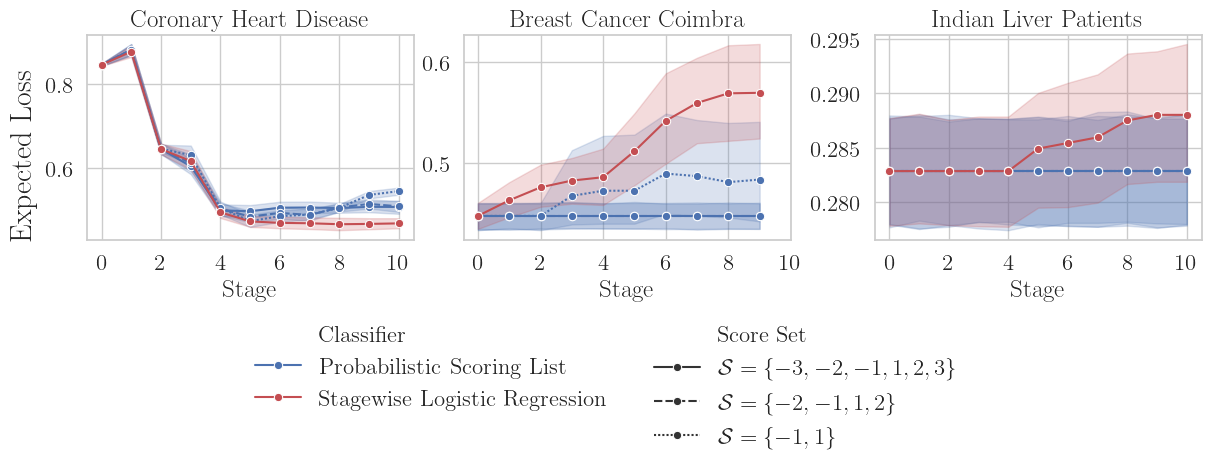

clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1000
             (-2, -1, 1, 2)           1000
             (-1, 1)                  1000
psl_logreg   (-3, -2, -1, 1, 2, 3)    1000
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64


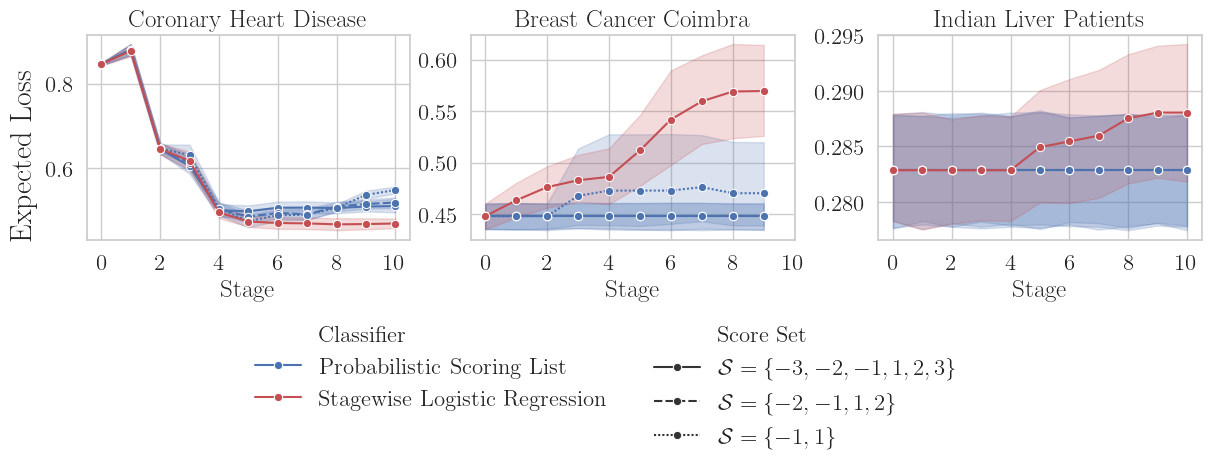

clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1000
             (-2, -1, 1, 2)           1000
             (-1, 1)                  1000
psl_logreg   (-3, -2, -1, 1, 2, 3)    1000
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64


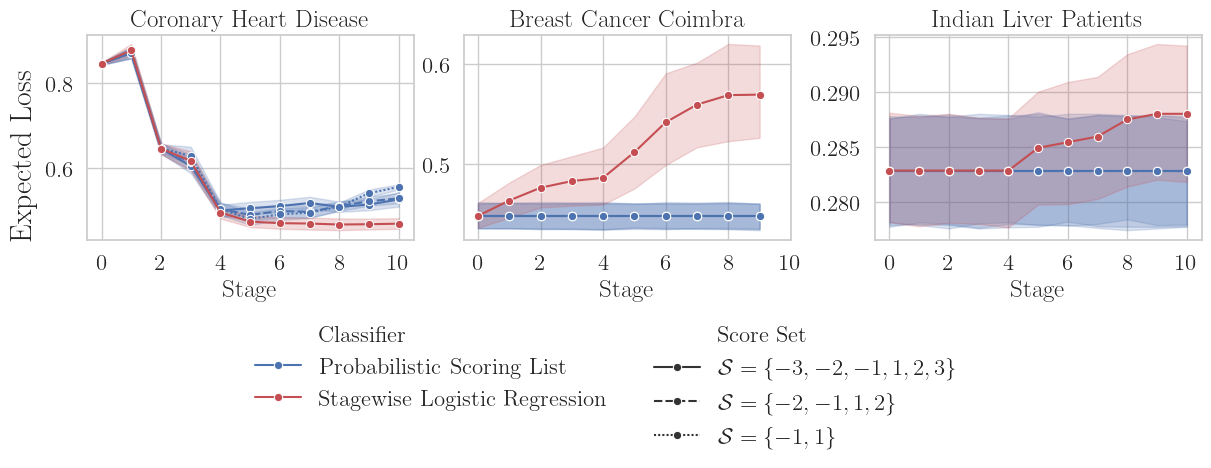

clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1000
             (-2, -1, 1, 2)           1000
             (-1, 1)                  1000
psl_logreg   (-3, -2, -1, 1, 2, 3)    1000
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64


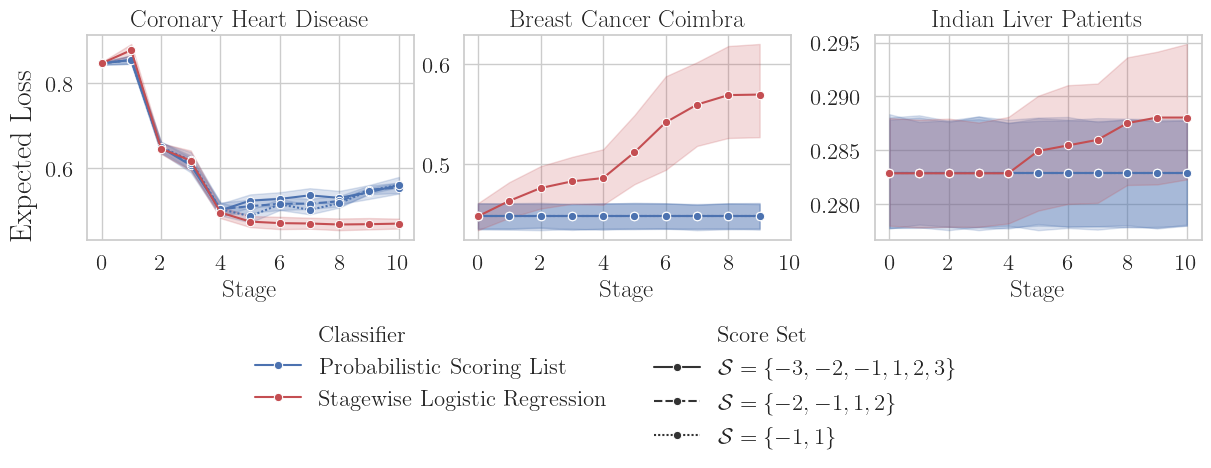

clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1000
             (-2, -1, 1, 2)           1000
             (-1, 1)                  1000
psl_logreg   (-3, -2, -1, 1, 2, 3)    1000
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64


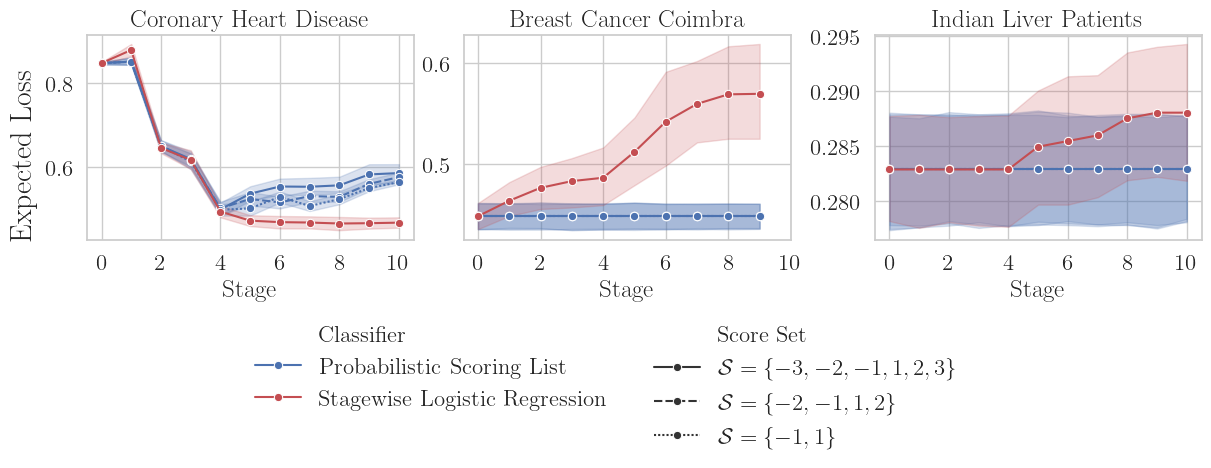

clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1000
             (-2, -1, 1, 2)           1000
             (-1, 1)                  1000
psl_logreg   (-3, -2, -1, 1, 2, 3)    1000
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64


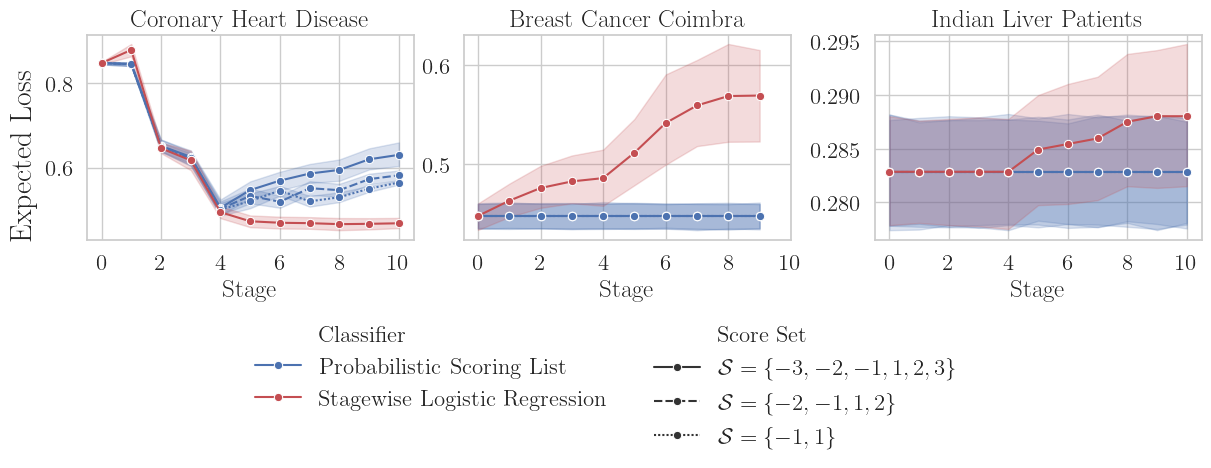

clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1000
             (-2, -1, 1, 2)           1000
             (-1, 1)                  1000
psl_logreg   (-3, -2, -1, 1, 2, 3)    1000
dtype: int64
clf_variant  score_set            
psl          (-3, -2, -1, 1, 2, 3)    1100
             (-2, -1, 1, 2)           1100
             (-1, 1)                  1100
psl_logreg   (-3, -2, -1, 1, 2, 3)    1100
dtype: int64


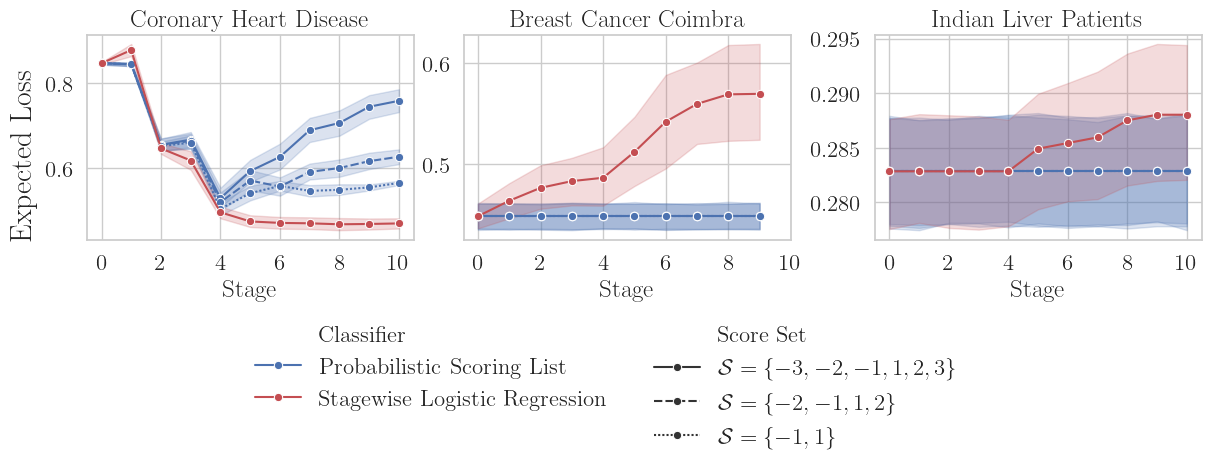

In [52]:
datasets = ["thorax", 42900, 41945]


for ci in [5, 10, 20, 50, 80, 90, 95, 99]:

    fig,axes = plt.subplots(1,len(datasets), sharey=False, layout='constrained')
    axes = axes.ravel()

    hue_order = ["psl", "","", "psl_logreg"]
    style_order = [(-3, -2, -1, 1, 2, 3), (-2, -1, 1, 2), (-1, 1)]


    for index, dataset in enumerate(datasets):
        ax=axes[index]

        df_ = df[(df.dataset == datasets[index])
        & (df.lookahead.isin({None,1}))
        & (df.clf_variant.isin(["psl", "psl_logreg"]))
        & (df.method.isin(["bisect"]))
        & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
        & (~df.stage.isnull())
        & (df.stage_loss=="expected_entropy")]
        

        df_ = df_.drop(df_[(df_.clf_variant=="psl_logreg") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
        df_ = df_.drop(df_[(df_.clf_variant=="psl_xgboost") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
        df_ = df_.drop(df_[(df_.clf_variant=="psl_random_forest") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
        df_ = df_.drop(df_[(df_.score_set == tuple(list(range(-50, 0)) + list(range(1, 51))))].index)
        sns.lineplot(data=df_, x="stage", y=f"test_conservative_wloss{ci}", hue="clf_variant", style="score_set", hue_order=hue_order, style_order=style_order, marker="o", ax=ax)
        #print(len(df_))
        #print(df_.score_set.value_counts())
        ax.get_legend().remove()
        ax.set_title(dataset_names[dataset])
        ax.set_ylabel(None)
        ax.set_xlabel("Stage")
        ax.set_xticks(list(range(0,11)))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        print(df_.groupby(["clf_variant", "score_set"]).size())
    syl = fig.supylabel(f"Expected Loss")
    label_mapping["psl"] = "Probabilistic Scoring List"
    label_mapping["clf_variant"] = "Classifier"

    handles, labels = ax.get_legend_handles_labels()
    labels = [label_mapping[label] for label in labels]
    proxy = Line2D([], [], linestyle='-', linewidth=0, color='white')
    handles.insert(3,proxy)
    labels.insert(3," ")
    lgd = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
    plt.show()
    # plt.savefig(f"fig/expected_loss_{ci}ci.pdf", bbox_inches='tight')

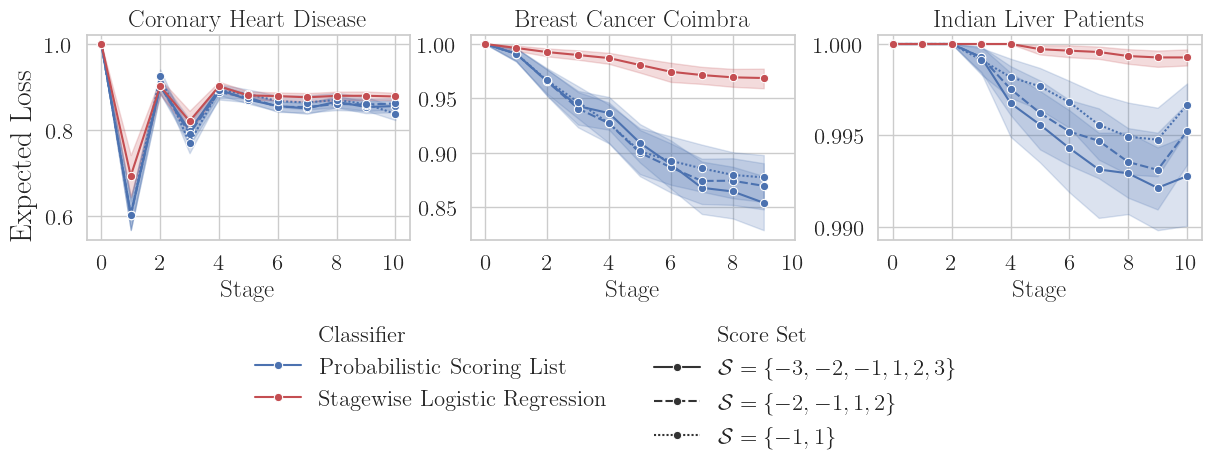

In [53]:
datasets = ["thorax", 42900, 41945]

fig,axes = plt.subplots(1,len(datasets), sharey=False, layout='constrained')
axes = axes.ravel()

hue_order = ["psl", "", "", "psl_logreg"]
style_order = [(-3, -2, -1, 1, 2, 3), (-2, -1, 1, 2), (-1, 1)]

for index, dataset in enumerate(datasets):
    ax=axes[index]

    df_ = df[(df.dataset == datasets[index])
    & (df.lookahead.isin({None,1}))
    & (df.clf_variant.isin(["psl", "psl_logreg"]))
    & (df.method.isin(["bisect"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())
    & (df.stage_loss=="expected_entropy")]
    
    df_ = df_.drop(df_[(df_.clf_variant=="psl_logreg") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
    sns.lineplot(data=df_, x="stage", y="test_recall_at_wloss", hue="clf_variant", style="score_set", hue_order=hue_order, style_order=style_order, marker="o", ax=ax)
    #print(len(df_))
    #print(df_.score_set.value_counts())
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
syl = fig.supylabel("Expected Loss")
label_mapping["psl"] = "Probabilistic Scoring List"
label_mapping["clf_variant"] = "Classifier"

handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
proxy = Line2D([], [], linestyle='-', linewidth=0, color='white')
handles.insert(3,proxy)
labels.insert(3," ")
lgd = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("fig/recall_at_expected_loss.pdf", bbox_inches='tight')

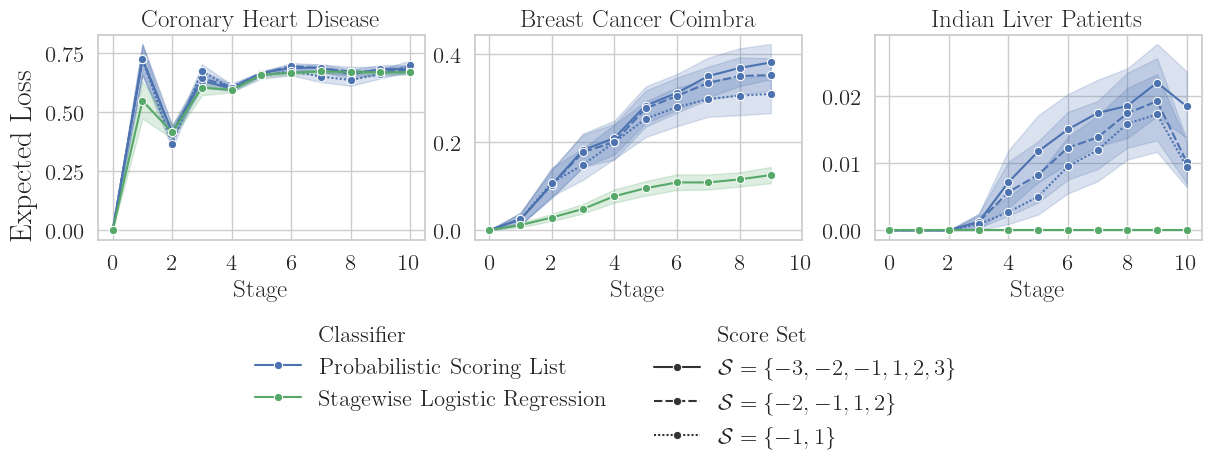

In [54]:
datasets = ["thorax", 42900, 41945]

fig,axes = plt.subplots(1,len(datasets), sharey=False, layout='constrained')
axes = axes.ravel()

hue_order = ["psl", "", "psl_logreg"]
style_order = [(-3, -2, -1, 1, 2, 3), (-2, -1, 1, 2), (-1, 1)]

for index, dataset in enumerate(datasets):
    ax=axes[index]

    df_ = df[(df.dataset == datasets[index])
    & (df.lookahead.isin({None,1}))
    & (df.clf_variant.isin(["psl", "psl_logreg"]))
    & (df.method.isin(["bisect"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())
    & (df.stage_loss=="expected_entropy")]

    
    df_ = df_.drop(df_[(df_.clf_variant=="psl_logreg") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
    #df_.test_spec_at_wloss  = 1- df_.test_spec_at_wloss
    sns.lineplot(data=df_, x="stage", y="test_spec_at_wloss", hue="clf_variant", style="score_set", hue_order=hue_order, style_order=style_order, marker="o", ax=ax)
    #print(len(df_))
    #print(df_.score_set.value_counts())
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
syl = fig.supylabel("Expected Loss")
label_mapping["psl"] = "Probabilistic Scoring List"
label_mapping["clf_variant"] = "Classifier"

handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
proxy = Line2D([], [], linestyle='-', linewidth=0, color='white')
handles.insert(3,proxy)
labels.insert(3," ")
lgd = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("fig/recall_at_expected_loss.pdf", bbox_inches='tight')

stage_loss
soft_ranking_loss    1100
expected_entropy     1100
Name: count, dtype: int64
stage_loss
expected_entropy     1000
soft_ranking_loss    1000
Name: count, dtype: int64
stage_loss
soft_ranking_loss    1100
expected_entropy     1100
Name: count, dtype: int64


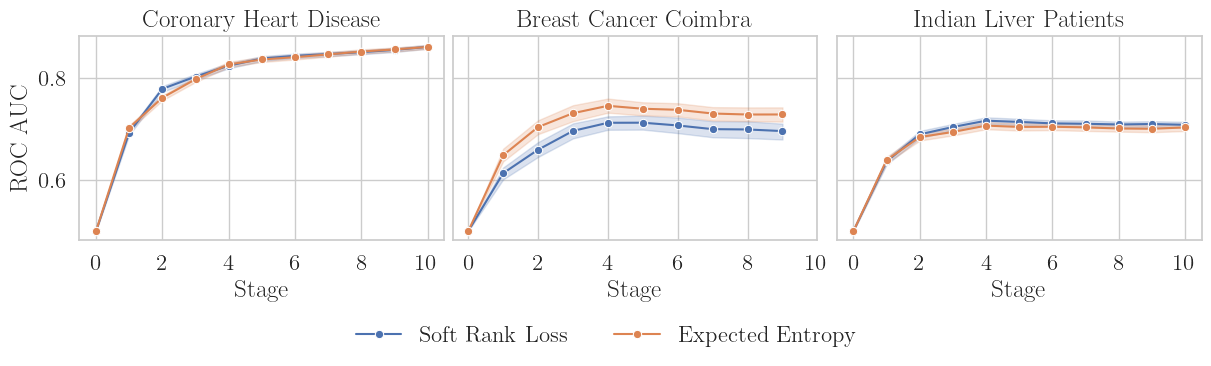

In [32]:
datasets = ["thorax", 42900, 41945]

fig,axes = plt.subplots(1,len(datasets), sharey=True, layout="constrained")
axes = axes.ravel()
hue_order = ["expected_entropy","soft_ranking_loss"]
for index, dataset in enumerate(datasets):
    ax=axes[index]
    df["stage_loss"] = df["stage_loss"].fillna("expected_entropy")
    df_ = df[
    (df.dataset == datasets[index])
    & (df.score_set==(-3, -2, -1, 1, 2, 3)) 
    & (df.lookahead.isin({None,1})) 
    & (df.clf_variant.isin(["psl"]))
    & (df.method.isin(["bisect"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())]
    # & (df.stage_loss.isin([None, "soft_rank_loss"]))]
    print(df_.stage_loss.value_counts())
    sns.lineplot(data=df_, x="stage", y="test_roc", hue="stage_loss", marker="o", ax=ax)
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(label_mapping["test_roc"])
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
lgd = fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("fig/roc_auc.pdf",bbox_extra_artists=(lgd,syl), bbox_inches='tight')